<a href="https://colab.research.google.com/github/Coen-Molyneaux/nuclear-log-nn/blob/main/nuclear_log_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: These notebooks are designed to be ran in colab

# The Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
CSV_PATH = "/content/drive/MyDrive/nuclear-log-nn/log.csv"
df = pd.read_csv(CSV_PATH)
df = df.drop('DPOR', axis=1) # DPOR is a purely derived quantity
df.head()

,Depth,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,CNLS,GR
0,195.0,226.0848,0.4076,69.8953,132.5052,-0.3548,0.1863,5.1090,1.8878,1.6973,-0.6303,30.0657,60.4576
1,195.5,223.5031,0.4063,69.2303,123.6225,-0.3619,0.1867,5.1031,1.8882,1.6791,-0.6409,26.7625,54.1495
2,196.0,221.4560,0.4047,68.4478,116.9258,-0.3668,0.1860,5.0872,1.8878,1.6585,-0.6539,27.6017,51.9944
3,196.5,219.8248,0.4033,67.4843,111.7925,-0.3613,0.1867,5.0881,1.8884,1.6435,-0.6649,31.5870,52.9645
4,197.0,218.1438,0.4023,66.3013,106.7821,-0.3569,0.1870,5.0972,1.8883,1.6390,-0.6705,35.8251,54.9659


# MLP Regression Network

In [19]:
import tensorflow as tf
import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# Extract labels RHOB and CNLS
Y = df[["RHOB", "CNLS"]].to_numpy()

# Extract features
X = df.drop(["RHOB", "CNLS"], axis=1).to_numpy()

scalerX = StandardScaler()
scalerY = StandardScaler()

X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)

print(X.shape)
print(Y.shape)

model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(2, activation="linear")
    ]
)

my_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=my_optimizer, loss="mse", metrics=["mae"])

model.summary()

(8739, 11)
(8739, 2)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,818 (136.01 KB)

 Trainable params: 34,818 (136.01 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Source: https://stackoverflow.com/questions/63435679
def reset_weights_tf2(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])


reset_weights_tf2(model)

In [24]:

model.fit(
    X_scaled, Y_scaled,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    shuffle=True
)

model.save_weights("model.weights.h5")


Y_pred_scaled = model.predict(X_scaled)
Y_pred = scalerY.inverse_transform(Y_pred_scaled)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5179 - mae: 0.5660 - val_loss: 0.1950 - val_mae: 0.3180
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2363 - mae: 0.3529 - val_loss: 0.2588 - val_mae: 0.3497
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1984 - mae: 0.3202 - val_loss: 0.2314 - val_mae: 0.3353
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1757 - mae: 0.2976 - val_loss: 0.2187 - val_mae: 0.3234
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1598 - mae: 0.2858 - val_loss: 0.1932 - val_mae: 0.3095
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1482 - mae: 0.2731 - val_loss: 0.1802 - val_mae: 0.3014
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1428 - mae: 0.2695 - val_loss: 0.1614 - val_mae: 0.2841
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1334 - mae: 0.2578 - val_loss: 0.1851 - val_mae: 0.3029
Epoch 9/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

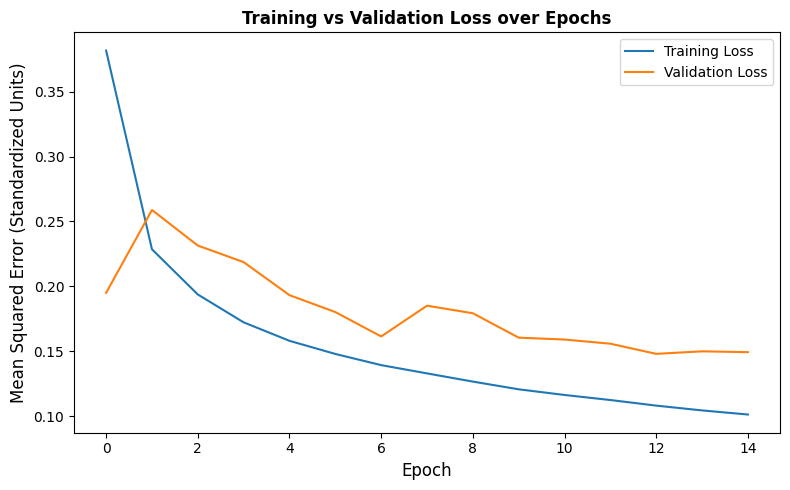

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss over Epochs', fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error (Standardized Units)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
